# Tools used

* Project Jupyter notebook
* Python
* Pandas library
* Open Street Map API
* Matplotlib
* Basemap
* Network X
* Open Data
* Shortest path (Dijkstra's algorithm)

In [ ]:
!sudo pip install pyshp

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import osmapi
import matplotlib
import matplotlib.cm as cm
import requests
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter
from scipy import spatial
import numpy as np
import pandas as pd # odd dependency, must import before basemap!
from mpl_toolkits.basemap import Basemap
import shapefile #pyshp
import pickle
import shapely
import geocoder
import geopy
from geopy.distance import vincenty
import networkx as nx
import sys
import os
from shapely import geometry
from lxml import etree
from collections import defaultdict
from io import StringIO, BytesIO

# For clarity, I moved some code from old notebooks into a python file

In [2]:
execfile('reused.py')

# Create a NetworkX graph of all LA city streets from OSM

In [3]:
g = nx.Graph()

intersection_check = defaultdict(list)

for road_id in roads.keys():
    road = roads[road_id]
    children = road.getchildren()
    ncount = 0
    for child in children:
        if child.tag=='nd':
            i = child.keys().index('ref')
            ref = child.values()[i]
            intersection_check[ref].append(road_id)

for road in roads.values():
    road_id = road.get('id')
    ncount = 0
    name = '?'
    hwtype = '?'
    last_ref = -1
    for child in road.getchildren():
        if child.tag=='tag':
            i = child.keys().index('k')
            j = child.keys().index('v')
            k = child.values()[i]
            v = child.values()[j]
            if k=='name':
                name = v
            if k=='highway':
                hwtype = v
    for child in road.getchildren():
        if child.tag=='nd':
            ref = child.get('ref')
            n = nodes[ref]
            lat = n[0]
            lon = n[1]
            ic = intersection_check[ref]
            if len(ic) > 1:
                g.add_node(ref, {'label': name, 'lat': lat, 'lon': lon})
            else:
                g.add_node(ref, {'label': '[intersection]', 'lat': lat, 'lon': lon})
            if ncount > 0:
                d = vincenty(nodes[ref], nodes[last_ref])
                if hwtype=='primary':
                    d *= 1
                if hwtype=='residential':
                    d *= 5
                else:
                    d *= 3
                w = d
                if last_ref != -1:
                    g.add_edge(ref, last_ref, {'weight': w.meters})
            ncount+=1
            last_ref = ref

# Create a KD-tree of the nodes

In [4]:
refids = []
roadids = []
lats = []
lons = []

for road in roads.values():
    road_id = road.get('id')
    for child in road.getchildren():
        if child.tag=='nd':
            refid = child.get('ref')
            ll = nodes[refid]
            refids.append(refid)
            roadids.append(road_id)
            lats.append(ll[0])
            lons.append(ll[1])

lldf = pd.DataFrame({'refid': refids, 'road_id': roadids, 'lat': lats, 'lon': lons})
data = zip(lldf.lon, lldf.lat)
rtree = spatial.KDTree(data)

In [5]:
# VALIDATION

print len(g.nodes())
print len(set(lldf.refid))

92189
92189


# Really naive driving directions

In [6]:
# Coffee Bean on South Beverly Glen Blvd and Santa Monica Blvd
lat = 34.057687
lon = -118.424526
n1 = rtree.query([lon, lat])

# DataScience HQ
lat = 33.9876562
lon = -118.3833794
n2 = rtree.query([lon, lat])

print 'matches:' + str([n1, n2])
n1 = lldf.loc[n1[1], 'refid']
n2 = lldf.loc[n2[1], 'refid']
print 'node ids: ' + n1 + ' ' + n2

matches:[(0.00027793411089918412, 56082), (0.00035527006629831946, 3984)]
node ids: 702389377 1773954221


In [7]:
path = nx.shortest_path(g, n1, n2, weight='weight')
npath = []
last = ''
lats = []
lons = []
labels = []
prev = {}
c = 0
alabels = []
for node in path:
    n = g.node[node]
    ll = nodes[node]
    lats.append(ll[0])
    lons.append(ll[1])
    label = n['label']
    try:
        i = prev[label] # a sloppy way of solving an intersection representation issue
    except KeyError:
        prev[label] = len(labels)
        i = -1
    alabels.append(label)
    if i > 0:
        labels = labels[0:(i+1)]
    else:
        if label != '[intersection]' and label != last:
            npath.append(label)
            last = label
            labels.append(label)


In [8]:
labels

['Santa Monica Boulevard',
 'South Beverly Glen Boulevard',
 'Linnington Avenue',
 'Patricia Avenue',
 'Louisiana Avenue',
 'Balsam Avenue',
 'Prosser Avenue',
 'Parnell Avenue',
 'Manning Avenue',
 'Pelham Avenue',
 'Overland Avenue',
 'Kinston Avenue',
 'Jefferson Boulevard',
 'Sepulveda Boulevard',
 'W Slauson Avenue',
 'Bristol Parkway',
 'Uplander Way']

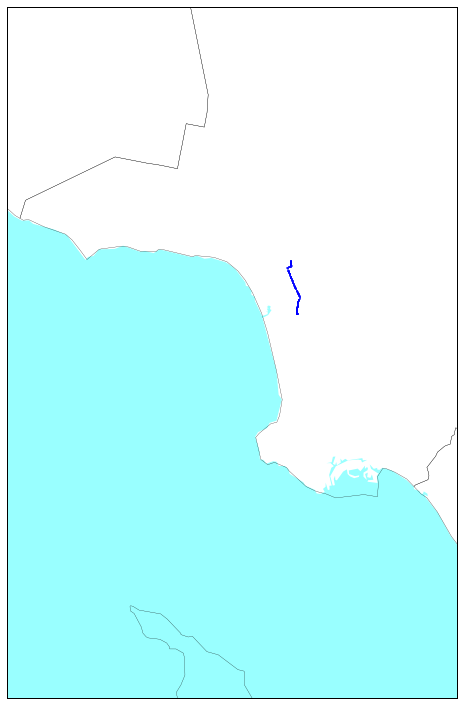

In [149]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
bmap = Basemap(projection='stere',lon_0=-100,lat_0=35.,\
            llcrnrlat=33.3,urcrnrlat=34.5,\
            llcrnrlon=-118.8,urcrnrlon=-118.2,\
            rsphere=6371200.,resolution='h',area_thresh=10000)
bmap.drawcountries()
bmap.drawcounties(linewidth=0.25)
bmap.drawmapboundary(fill_color='#99ffff')
bmap.fillcontinents(color='#ffffff',lake_color='darkblue', zorder=0)
bmap.drawrivers()

x, y = bmap(lons, lats)
bmap.scatter(x,y,s=1,marker='o',color='b')

plt.show()

# Retrieve Active Businesses from LA Open Data Portal

In [9]:
# GET DATA ON ACTIVE BUSINESSES IN LOS ANGELES

fname = 'businesses.csv'
if not(os.path.isfile(fname)):
    url = 'https://data.lacity.org/A-Prosperous-City/Listing-of-Active-Businesses/6rrh-rzua'
    print 'Getting ' + url
    r = requests.get(url)
    f = open('businesses.csv', 'w')
    f.write(r.text.encode('utf-8'))
    f.close()
businesses = pd.read_csv('businesses.csv')

## Select just grocery stores

In [110]:
# SELECT ALL GROCERY STORES AND AGGREGATE

filter = businesses['PRIMARY NAICS DESCRIPTION'] == 'Grocery stores (including supermarkets & convenience stores without gas)'
groceries = businesses[filter].copy()
gp = pd.DataFrame(groceries.groupby('BUSINESS NAME')['LOCATION ACCOUNT #'].count())
gp.reset_index(inplace=True)
gp.columns = ['name', 'freq']
gp.sort('freq', ascending=False, inplace=True)
gp[1:20]

,name,freq
1380,THE VONS COMPANIES INC,27
1395,TRADER JOE'S CO,18
739,KENK USA INC,15
424,"FRESH & EASY, LLC",14
439,GELSON'S MARKETS,10
148,BERBERIAN ENTERPRISES INC,10
1048,NUMERO UNO ACQUISITIONS LLC,8
52,ALBERTSONS LLC,8
992,MOTHERS NUTRITIONAL CENTER INC,7
1334,SUPER CENTER CONCEPTS INC,6


## Quick web search on unrecognized names reveals...

BERBERIAN ENTERPRISES INC = Jons

KENK USA INC = Tesoro (gas / convenience)

# Label Stores

Ideally, I'd like to be labeling these stores based on whether or not they're a full grocery store or not.

In leiu of that, let's look at access to large chains (accept some false negatives).

In [113]:
# CRUDELY LABEL THOSE THAT ARE CHAINS

groceries['chain'] = 0

chains = ['THE VONS COMPANIES INC', "TRADER JOE'S CO", 'FRESH & EASY, LLC', "GELSON'S MARKETS"
          , "BERBERIAN ENTERPRISES INC", 'NUMERO UNO ACQUISITIONS LLC', 'ALBERTSONS LLC'
          , 'MOTHERS NUTRITIONAL CENTER INC', 'THE VONS COMPANIES INC', "TRADER JOE'S CO", 'FRESH & EASY, LLC'
          , "GELSON'S MARKETS", "BERBERIAN ENTERPRISES INC", 'NUMERO UNO ACQUISITIONS LLC'
          , 'ALBERTSONS LLC', 'MOTHERS NUTRITIONAL CENTER INC']

for chain in chains:
    filter = groceries['BUSINESS NAME'] == chain
    groceries.loc[filter, 'chain'] = 1

chains = groceries[groceries.chain==1].copy()

In [114]:
# LOAD ANY CACHED GEO-CODED LOCATIONS, RETRIEVE THE REST VIA API AND SAVE
# DATASET HAS LOCATIONS, BUT THEY AREN'T VERY PRECISE AND SOME ARE MISSING

full_address = chains.apply(lambda x: x['STREET ADDRESS'] + ', ' + x['CITY'] + ', CA ' + x['ZIP CODE'], axis=1)
chains['FULL ADDRESS'] = full_address

gfname = 'geocoded.pkl'
gresults = {}
if os.path.isfile(gfname):
    print 'Retrieving previous geo-coded data'
    f = open(gfname, 'r')
    gresults = pickle.load(f)
    f.close()

for f in full_address:
    try:
        loc = gresults[f]
    except KeyError:
        try:
            print 'Retrieving ' + f
            loc = geocoder.google(f)
            gresults[f] = loc.latlng
            time.sleep(1)
        except GeocoderTimedOut:
            time.sleep(60)

f = open(gfname, 'wb')
pickle.dump(gresults, f)
f.close()

Retrieving previous geo-coded data


In [115]:
# ENRICH THE DATAFRAME

lats = []
lons = []
for f in full_address:
    loc = gresults[f]
    lats.append(loc['lat'])
    lons.append(loc['lng'])

chains['lat'] = lats
chains['lon'] = lons

In [14]:
# LET'S CACHE THE RESULTS BECAUSE A LOT OF DATA MUNGING IS NOW DONE

chains.to_csv('chains.tsv', set='\t')

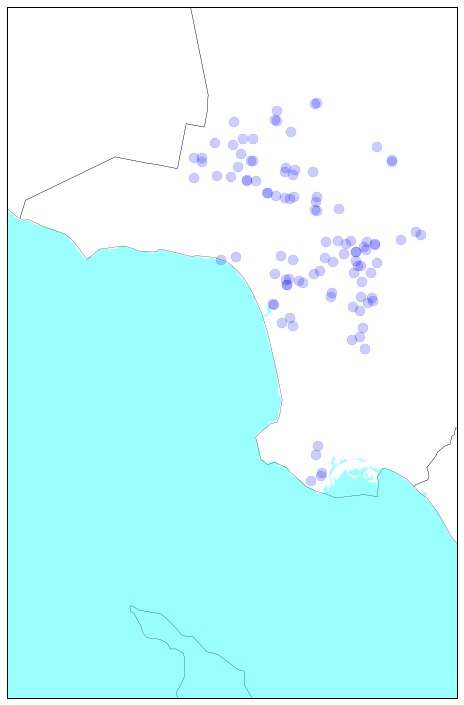

In [30]:
# VISUALIZE THE CHAINS

fig = plt.figure(figsize=(12,12))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
bmap = Basemap(projection='stere',lon_0=-100,lat_0=35.,\
            llcrnrlat=33.3,urcrnrlat=34.5,\
            llcrnrlon=-118.8,urcrnrlon=-118.2,\
            rsphere=6371200.,resolution='h',area_thresh=10000)
bmap.drawcountries()
bmap.drawcounties(linewidth=0.25)
bmap.drawmapboundary(fill_color='#99ffff')
bmap.fillcontinents(color='#ffffff',lake_color='darkblue', zorder=0)
bmap.drawrivers()

x, y = bmap(lons, lats)
bmap.scatter(x,y,100,marker='o',color='b', alpha=0.2)

plt.show()

In [ ]:
# FIND NEAREST NODE TO EACH

In [15]:
nearest_intersection = []
for i in range(chains.shape[0]):
    row = chains.iloc[i]
    r = rtree.query([row.lon, row.lat])
    rownum = r[1]
    refid = lldf.loc[rownum, 'refid']
    nearest_intersection.append(refid)

In [54]:
# GET DISTANCE TO ALL NODES FROM FIRST GROCERY STORE

ni = nearest_intersection[0]
spaths = nx.single_source_dijkstra_path_length(g, source=ni, weight='meters')
df = pd.DataFrame({'start': ni, 'dest': spaths.keys(), 'dist': spaths.values()})

In [55]:
last_update = -1
for i in range (1, len(nearest_intersection)):
    u = int(10.0 * i / len(nearest_intersection))
    if u != last_update:
        print str(u*10) + '% complete'
        last_update = u
    ni = nearest_intersection[i]
    spaths = nx.single_source_dijkstra_path_length(g, source=ni, weight='meters')
    df2 = pd.DataFrame({'start': ni, 'dest': spaths.keys(), 'dist': spaths.values()})
    m = pd.merge(df, df2, on=['dest'])
    xmin = m['dist_x'] <= m['dist_y']
    m['dist'] = 9999
    m.ix[xmin, 'dist'] = m[xmin]['dist_x']
    m.ix[xmin, 'start'] = m[xmin]['start_x']
    m.ix[~xmin, 'dist'] = m[~xmin]['dist_y']
    m.ix[~xmin, 'start'] = m[~xmin]['start_y']
    m.drop('dist_x', axis=1, inplace=True)
    m.drop('dist_y', axis=1, inplace=True)
    m.drop('start_x', axis=1, inplace=True)
    m.drop('start_y', axis=1, inplace=True)
    df = m

0% complete
10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete


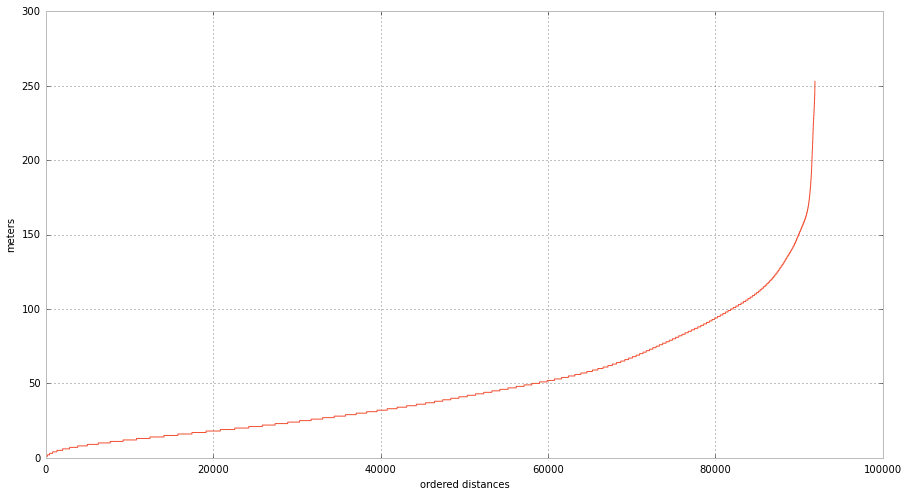

In [117]:
df.sort('dist', inplace=True)
df.index = np.arange(df.shape[0])
plt.figure(figsize=(15,8))
plt.plot(df.index, df.dist)
plt.xlabel('ordered distances')
plt.ylabel('meters')
plt.show()

In [81]:
cutoff = np.percentile(df.dist, 95)
desert_df = df[df.dist > cutoff]
desert_df.columns = ['location_id', 'dist', 'nearest_store_id']
desert_df.index = np.arange(desert_df.shape[0])

In [82]:
desert_df.head()

,location_id,dist,nearest_store_id
0,1974141035,125,700726062
1,2337333381,125,2380390731
2,2090778421,125,441910921
3,1908503232,125,700726062
4,1488571831,125,14760044


In [86]:
deserts = []
for lid in desert_df['location_id']:
    deserts.append(nodes[lid])

In [96]:
df3 = pd.DataFrame(deserts)
df3.columns = ['lat', 'lon']

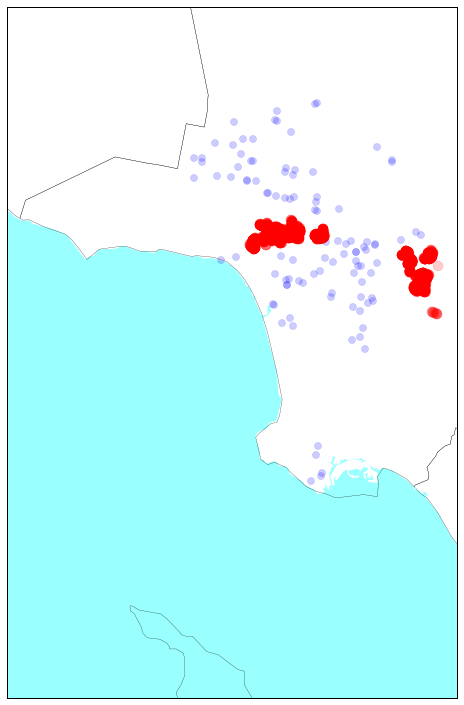

In [109]:
# VISUALIZE THE CHAINS

fig = plt.figure(figsize=(12,12))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
bmap = Basemap(projection='stere',lon_0=-100,lat_0=35.,\
            llcrnrlat=33.3,urcrnrlat=34.5,\
            llcrnrlon=-118.8,urcrnrlon=-118.2,\
            rsphere=6371200.,resolution='h',area_thresh=10000)
bmap.drawcountries()
bmap.drawcounties(linewidth=0.25)
bmap.drawmapboundary(fill_color='#99ffff')
bmap.fillcontinents(color='#ffffff',lake_color='darkblue', zorder=0)
bmap.drawrivers()

x, y = bmap(lons, lats)
bmap.scatter(x,y,50,marker='o',color='b', alpha=0.2)

x, y = bmap(df3.lon.tolist(), df3.lat.tolist())
bmap.scatter(x,y,100,marker='o',color='r', alpha=0.2)

plt.show()

# Criticism and Next Steps

* Incomplete list of grocery locations (only LA proper)
* Weak choice on what constitutes and acceptable grocery store
* Distance does not really reflect realistic driving routes
* Distance does not consider public transit access, nor transit riders
* Fails to account for affluent people in the hills